# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

### Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

### Importación de Datos

In [ ]:
df=pd.read_csv('taxi.csv',index_col=[0],parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
#Agrupación de pedidos por cada hora
df_hora = df.resample('1H').sum()
df_hora

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Análisis

### Análisis de Estacionareidad 

**Gráfico Serie Pura**

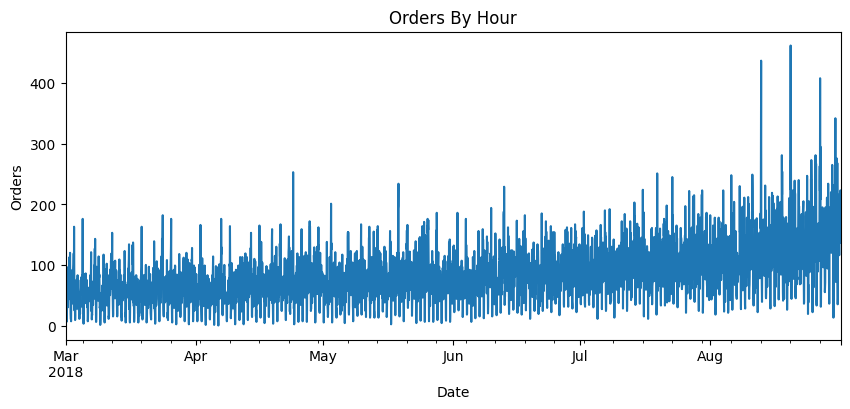

In [5]:
df_hora.plot(figsize=[10,4],legend='')
plt.title('Orders By Hour')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.show()

**Gráfico Media de los Pedidos**

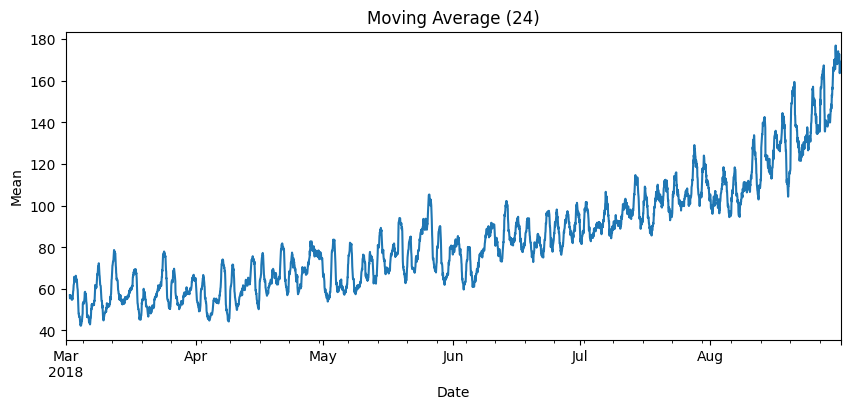

In [6]:
df_hora.rolling(24).mean().plot(legend='',figsize=[10,4])
plt.title('Moving Average (24)')
plt.xlabel('Date')
plt.ylabel('Mean')
plt.show()

**Gráfico Desviación Estándar de los Pedidos**

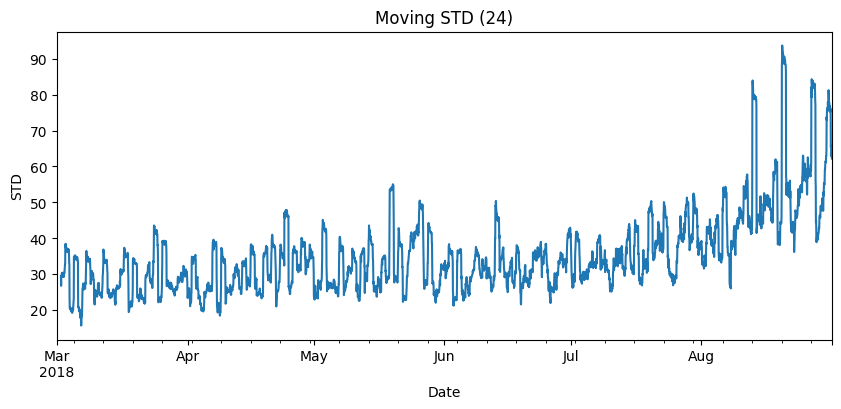

In [7]:
df_hora.rolling(24).std().plot(legend='',figsize=[10,4])
plt.title('Moving STD (24)')
plt.xlabel('Date')
plt.ylabel('STD')
plt.show()

- Tomamos en cuenta las 24 horas (1 día) anteriores en la media y desviación móviles.
- Mirando las gráficas de los datos de órdenes, parece que la media va en aumento a medida que avanza el año.
- De igual forma, parece ser que la varianza crece en el mes de agosto.
- Aunque lo sugieren las gráficas, no podemos afirmar con toda certeza que la serie no es estacionaria.

**Comprobación Estadística Dickey - Fuller**

Vamos a plantear una prueba de hipótesis donde:
- H0 (Hipótesis Nula): La serie no es estacionaria
- H1 (Hipótesis Alternativa): La serie es estacionaria

In [8]:
#Ejecución test Dickey-Fuller
p_value = adfuller(df_hora)[1]

print(f"El valor p es: {p_value:.2%}")

if p_value < 0.05:
    print('Se rechaza la hipótesis nula, La serie se puede considerar estacionaria')
else:
    print('No se puede rechazar la hipótesis nula, La serie se puede considerar no estacionaria')

El valor p es: 2.89%
Se rechaza la hipótesis nula, La serie se puede considerar estacionaria


### Autocorrelación

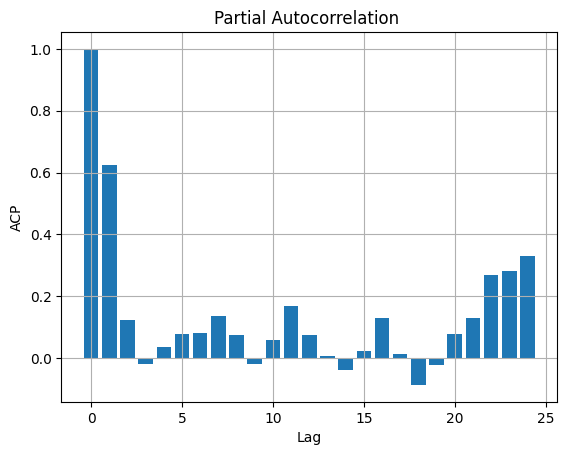

In [9]:
#Cálculo de la autocorrelación
acp = pacf(df_hora, nlags = 24)
plt.bar(x=range(25), height=acp)
plt.grid()
plt.title('Partial Autocorrelation ')
plt.xlabel('Lag')
plt.ylabel('ACP')
plt.show()

- Se realizó un análisis de auto correlación para determinar el grado en el que los días pasados pueden predecir el día actual.
- Se evidencia que el día anterior tiene la mayor auto correlación, con un valor de 0.6.
- El resto de días parecen tener un nivel muy bajo, aunque los días del 22 a 24 pasados tiene un nivel un poco superior(0.3) que podría ser relevante.
- Con este análisis se determina cantidad de atributos que se van a generar para ayudar a entrenar el modelo.

## Formación

In [10]:
#Generación de una copia para que sea modificada
df_hora2 = df_hora.copy()

### Generación Media Movil

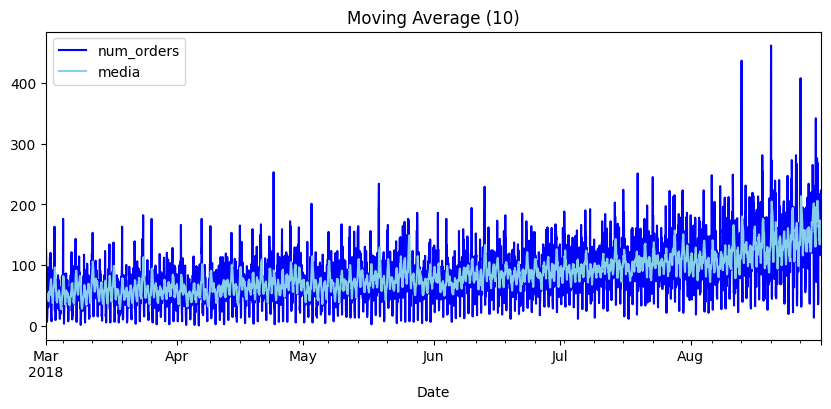

In [11]:
#Adicionar media movil de ventana 10
df_hora2['media']=df_hora2.shift().rolling(10).mean()
df_hora2.plot(color=('blue','skyblue'),figsize=[10,4])
plt.title('Moving Average (10)')
plt.ylabel('')
plt.xlabel('Date')
plt.show()

### Inclusión Datos de Fecha

In [12]:
#Generamos datos a partir del mes (año no cambia) 
df_hora2['month'] = df_hora.index.month
df_hora2['day'] = df_hora.index.day
df_hora2['hour'] = df_hora.index.hour
df_hora2.head(25)

,num_orders,media,month,day,hour
datetime,,,,,
2018-03-01 00:00:00,124,NaN,3,1,0
2018-03-01 01:00:00,85,NaN,3,1,1
2018-03-01 02:00:00,71,NaN,3,1,2
2018-03-01 03:00:00,66,NaN,3,1,3
2018-03-01 04:00:00,43,NaN,3,1,4
2018-03-01 05:00:00,6,NaN,3,1,5
2018-03-01 06:00:00,12,NaN,3,1,6
2018-03-01 07:00:00,15,NaN,3,1,7
2018-03-01 08:00:00,34,NaN,3,1,8


### Generación de Desfases

In [13]:
#Creación Desfases de acuerdo al gráfico de Autocorrelación
df_hora2['lag_1'] = df_hora.shift()
df_hora2['lag_22'] = df_hora.shift(22)
df_hora2['lag_23'] = df_hora.shift(23)
df_hora2['lag_24'] = df_hora.shift(24)
df_hora2.head(25)

,num_orders,media,month,day,hour,lag_1,lag_22,lag_23,lag_24
datetime,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,0,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,1,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,1,2,85.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,1,3,71.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,1,4,66.0,NaN,NaN,NaN
2018-03-01 05:00:00,6,NaN,3,1,5,43.0,NaN,NaN,NaN
2018-03-01 06:00:00,12,NaN,3,1,6,6.0,NaN,NaN,NaN
2018-03-01 07:00:00,15,NaN,3,1,7,12.0,NaN,NaN,NaN
2018-03-01 08:00:00,34,NaN,3,1,8,15.0,NaN,NaN,NaN


## Prueba

### Eliminación Datos Faltantes

In [14]:
df_hora2.dropna(inplace=True)

### Separación Conjunto de Datos

In [15]:
#Separación atributos - objetivo
features = df_hora2.drop(columns='num_orders',axis=1)
target = df_hora2['num_orders']

In [16]:
#Separación datos de entrenamiento-prueba (10%)
features_train,features_test,target_train,target_test = train_test_split(features,target,
                                                                         test_size=0.1,
                                                                         shuffle=False,
                                                                        random_state=1234)
#Comprobación de tamaños separación
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3952, 8)
(440, 8)
(3952,)
(440,)


### Regresión Lineal

In [17]:
#Entrenamiento
lineal = LinearRegression()
lineal.fit(features_train,target_train)
#Predicción
lineal_pred = lineal.predict(features_test)
#Métrica Error
recm = mean_squared_error(target_test,lineal_pred)**0.5
print(f'RECM Regresión Lineal: {recm:.2f}')

RECM Regresión Lineal: 45.85


### Bosque Aleatorio

In [18]:
#Variable RECM
recm_bosque = 50


#Lazo de prueba de hiperparámetros
for i in range (10,150,30):
    for j in range(1,10,2):
        bosque = RandomForestRegressor (n_estimators=i, max_depth=j,random_state=1234)
        #Entrenamiento
        bosque.fit(features_train,target_train)
        #Predicción
        bosque_pred = bosque.predict(features_test)
        #Métrica Error
        recm = mean_squared_error(target_test,bosque_pred)**0.5
        if recm < recm_bosque:
            recm_bosque = recm


print(f"RECM Bosque Aleatorio: {recm_bosque:.2f}")


RECM Bosque Aleatorio: 44.43


### LGBM

In [19]:
#Variable RECM
recm_lgbm = 100

#Lazo de prueba de hiperparámetros
for r in range(1,50,10):
    for n in range(50,150,50):
        #Entrenamiento
        lgbm = LGBMRegressor(learning_rate=(r/10), n_estimators=n, random_state=1234,
                             verbose = -1).fit(features_train,target_train)

        #Predicción
        lgbm_pred= lgbm.predict(features_test)
        #Métrica Error
        recm = mean_squared_error(target_test,lgbm_pred)**0.5
        if recm < recm_lgbm:
            recm_lgbm = recm

print(f"RECM LightGBM: {recm_lgbm:.2f}")


RECM LightGBM: 41.10


## Conclusiones

- Aunque inicialmente consideramos a la serie no estacionaria de acuerdo a los gráficos, comprobamos que si tenía esta característica mediante una prueba estadística.
- Usamos el parámetro de auto correlación para determinar los desfases que predicen mejor los valores futuros, determinando que eran el 1, 22, 23,24. Se hizo una prueba con 1 solo defase, y el RECM en todos los modelos aumentó.
- Creamos atributos que contribuyeron al modelo, como el mes, día y hora.
- Creamos como atributo a la media móvil, se realizaron pruebas con venta de: 1-10-24, obervando una ligera mejora en el RECM en 10 respcto a 1. El aumento a ventana de 24 no tuvo efecto.
- El error de la regresión lineal podría mejorar si se estadarizan los datos.
- El modelo con potenciación de gradiente ajustando hiperparámetros fue el mas efectivo a la hora de predecir.
- Se consiguió el objetivo de tener un modelo que puede predecir el número de pedidos cada hora, con una métrica de error menor a 48.